In [1]:
import os
import json

import numpy as np
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_classifier.evaluation import Evaluator
from meld_classifier.experiment import Experiment

import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns 




Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 


2023-03-29 15:25:20.906480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/software/master/miniconda/3/lib:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/daal/lib/intel64_lin:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/daal/../tbb/lib/intel64_lin/gcc4.4:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/ipp/lib/intel64:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/tbb/lib/intel64/gcc4.7:/usr/local/Cluster-Apps/intel/2017.4/debugger_2017/iga/lib:/usr/local/Cluster-Apps/intel/2017.4/debugger_2017/libipt/intel64/lib:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/mpi/intel64/lib:/usr/local/Cluster-Apps/intel/2017.4/compilers_and_libraries_2017.4.196/linux/t

In [2]:
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')

In [3]:
model_path1 = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-03-07_QRYP_classification_distance_head/s_0/'
model_path2 = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-03-07_VEYP_classification_distance/s_0/'

folds = np.arange(0,5)

save_dirs = {
    'distance_head': [os.path.join(model_path1,f'fold_0{fold}', 'results') for fold in folds],
    'miccai_model': [os.path.join(model_path2,f'fold_0{fold}', 'results') for fold in folds],
    'per_vertex':'/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results/predictions_ensemble_iteration.hdf5'
}

In [4]:
n_vert = len(cohort.cortex_label)*2

In [15]:
with h5py.File(os.path.join(save_dirs['distance_head'][0], 'predictions.hdf5'), "r") as f:
    subjects = list(f.keys())
len(subjects)

453

In [6]:
import scipy
def cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0):
    """cluster predictions and threshold based on min_area_threshold

    Args:
        mask: boolean mask of the per-vertex lesion predictions to cluster"""
    n_comp, labels = scipy.sparse.csgraph.connected_components(cohort.adj_mat[mask][:, mask])
    islands = np.zeros(len(mask))
    # only include islands larger than minimum size.
    for island_index in np.arange(n_comp):
        include_vec = labels == island_index
        size = np.sum(include_vec)
        if size >= min_area_threshold:
            island_count += 1
            island_mask = mask.copy()
            island_mask[mask] = include_vec
            islands[island_mask] = island_count
    return islands

def load_prediction(subject,hdf5,dset='prediction'):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi][dset][:]
    return results

In [16]:
#get TP cluster size based on threshold
import pandas as pd

#parameters for graph
threshold_value = 0.03
min_area_threshold=0
print(threshold_value)

df=pd.DataFrame()
subjects_dictionary={}
values_subj={}
for si,subj in enumerate(subjects):
    if si%100==0:
        print(si)
    values_subj['ID']=subj
    s = MeldSubject(subj,cohort=cohort)
    values_subj['age']=s.get_demographic_features('Age at preop')
    values_subj['group']=s.group
    values_subj['MRI negative']=s.get_demographic_features('Ever reported MRI negative')
    values_subj['histopathology']=s.get_demographic_features('Histology')
    labels_hemis = {}
    dists={}
    labels = np.zeros(n_vert)
    for hemi in ['lh','rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    
    for model in set(save_dirs):
        values={}
        if model == 'per_vertex':
            #load pred from old classifier
            pred_file_old = os.path.join(save_dirs['per_vertex'])
            result_hemis_old = load_prediction(subj,pred_file_old, dset='prediction')
            #relabel cluster value for rh
            result_hemis_old['rh'][result_hemis_old['rh']>0]= result_hemis_old['rh'][result_hemis_old['rh']>0]+(len(set(result_hemis_old['lh']))-1)
            result_old = np.hstack([result_hemis_old['lh'],result_hemis_old['rh']])
            
            values['classifier']=model
            values['number_clusters']=len(set(result_hemis_old['lh']))+len(set(result_hemis_old['rh']))-2
            # values['size_cluster'] = (result_hemis_old['lh']>0).sum()+(result_hemis_old['rh']).sum()
        
            #add detection
            if labels.sum()>0:
                values['sensitivity'] = np.logical_and(result_old, labels).any()
                values['sensitivity_plus'] = np.logical_and(result_old, borderzones).any()
                values['size_lesion'] = labels.sum()
                #find tp clusters
                tp_cluster_value=list(set(result_old[borderzones.astype('bool')]))[1::]
                values['number_tp_clusters'] = len(tp_cluster_value)
                if len(tp_cluster_value) > 0:
                    values['size_tp_clusters'] = np.in1d(result_old,tp_cluster_value).sum()
            #store specificity for controls (no label)
            else:
                values['specificity'] = ~result_old.any()
            df=pd.concat([df,pd.DataFrame([{**values_subj, **values}])])
    
            #load pred from classifiers
        else:
            result_hemis={'lh':np.zeros(int(n_vert/2)),
                        'rh':np.zeros(int(n_vert/2)),}
            result_hemis_clustered={}
            for fold in folds:
                save_dir = save_dirs[model][fold]
                #load pred from new classifier and average over fold
                pred_file = os.path.join(save_dir, 'predictions.hdf5')
                result_hemis_fold = load_prediction(subj,pred_file, dset='prediction')
                result_hemis['lh'] += result_hemis_fold['lh']/len(folds)
                result_hemis['rh'] += result_hemis_fold['rh']/len(folds)
            for h, hemi in enumerate(['lh', 'rh']):
                #threshold new predictions
                mask = np.zeros(len(cohort.cortex_mask), dtype=bool)
                mask[cohort.cortex_mask] = (result_hemis[hemi] >= threshold_value)
                #cluster new predictions
                result_hemis_clustered[hemi] = cluster_and_area_threshold(cohort, mask, min_area_threshold=min_area_threshold)[cohort.cortex_mask]
            #relabel cluster value for rh
            result_hemis_clustered['rh'][result_hemis_clustered['rh']>0]= result_hemis_clustered['rh'][result_hemis_clustered['rh']>0]+(len(set(result_hemis_clustered['lh']))-1)
            result_clustered = np.hstack([result_hemis_clustered['lh'],result_hemis_clustered['rh']])
            values['classifier']=model
            values['number_clusters']=len(set(result_hemis_clustered['lh']))+len(set(result_hemis_clustered['rh']))-2
            # values['size_cluster'] = (result_clustered>0).sum()
            #add detection
            if labels.sum()>0:
                values['sensitivity'] = np.logical_and(result_clustered, labels).any()
                values['sensitivity_plus'] = np.logical_and(result_clustered, borderzones).any()
                #find tp clusters
                tp_cluster_value=list(set(result_clustered[borderzones.astype('bool')]))[1::]
                values['number_tp_clusters'] = len(tp_cluster_value)
                if len(tp_cluster_value) > 0:
                    values['size_tp_clusters'] = np.in1d(result_clustered,tp_cluster_value).sum()
            #store specificity for controls (no label)
            else:
                values['specificity'] = ~result_clustered.any()
        
            df=pd.concat([df,pd.DataFrame([{**values_subj, **values}])])

0.03
0
100
200
300
400


In [17]:
df

,ID,age,group,MRI negative,histopathology,classifier,number_clusters,sensitivity,sensitivity_plus,number_tp_clusters,size_tp_clusters,size_lesion,specificity
0,MELD2_H7_3T_FCD_001,10.0,patient,0.0,FCD_1,miccai_model,14,False,False,0.0,NaN,NaN,NaN
0,MELD2_H7_3T_FCD_001,10.0,patient,0.0,FCD_1,distance_head,19,False,True,2.0,2.0,NaN,NaN
0,MELD2_H7_3T_FCD_001,10.0,patient,0.0,FCD_1,per_vertex,3,False,False,0.0,NaN,2913.0,NaN
0,MELD2_H7_3T_FCD_004,12.0,patient,0.0,FCD_1,miccai_model,25,True,True,8.0,10660.0,NaN,NaN
0,MELD2_H7_3T_FCD_004,12.0,patient,0.0,FCD_1,distance_head,25,True,True,23.0,19249.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,MELD_H9_3T_FCD_0005,46.0,patient,0.0,FCD_2B,distance_head,13,True,True,1.0,16052.0,NaN,NaN
0,MELD_H9_3T_FCD_0005,46.0,patient,0.0,FCD_2B,per_vertex,3,True,True,2.0,1074.0,454.0,NaN
0,MELD_H9_3T_FCD_0010,20.0,patient,1.0,NaN,miccai_model,29,False,False,0.0,NaN,NaN,NaN
0,MELD_H9_3T_FCD_0010,20.0,patient,1.0,NaN,distance_head,9,False,False,0.0,NaN,NaN,NaN


(0.0, 20000.0)

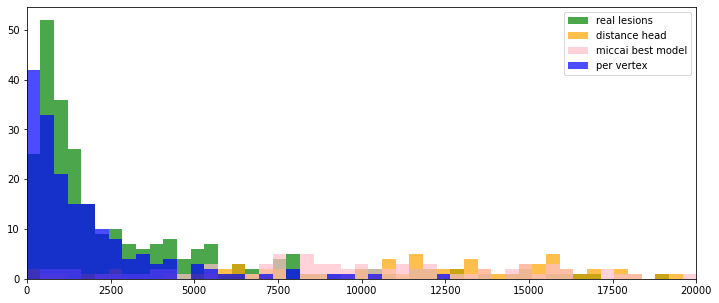

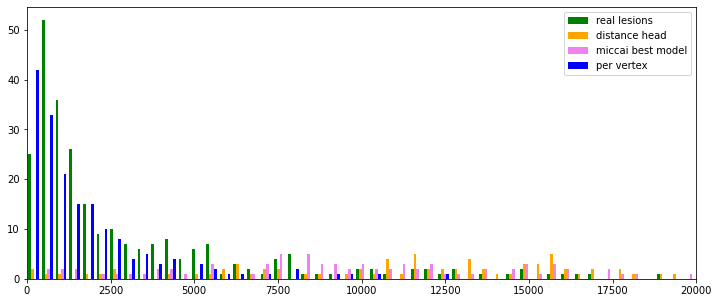

In [18]:
# plot lesion size distribution 
a=df[(df['classifier']=='per_vertex')&(df['group']=='patient')]['size_lesion']
b=df[(df['classifier']=='distance_head')&(df['sensitivity_plus'])]['size_tp_clusters']
c=df[(df['classifier']=='miccai_model')&(df['sensitivity_plus'])]['size_tp_clusters']
d= df[(df['classifier']=='per_vertex')&(df['sensitivity_plus'])]['size_tp_clusters']

plt.figure(figsize=(12,5))
# bins=np.histogram(np.hstack((a,b,c,d)), bins=100)[1] #get the bin edges
bins=np.linspace(0,20000,50) #get the bin edges
plt.hist(a, bins=bins, color='green', alpha=0.7, label='real lesions')
plt.hist(b, bins=bins, color='orange', alpha=0.7, label='distance head')
plt.hist(c, bins=bins, color='pink', alpha=0.7, label='miccai best model')
plt.hist(d, bins=bins, color='blue', alpha=0.7, label='per vertex')
plt.legend()
plt.xlim([0,20000])

plt.figure(figsize=(12,5))
bins=np.linspace(0,20000,50) #get the bin edges
plt.hist([a,b,c,d], bins=bins, color=['green','orange', 'violet', 'blue'], label=['real lesions','distance head','miccai best model', 'per vertex'])
plt.legend()
plt.xlim([0,20000])

### plot examples

In [19]:
def create_surface_plots(coords,faces,overlay,parcel=None, flat_map=True):
    """plot and reload surface images"""
    from meld_classifier.meld_plotting import trim
    import matplotlib_surface_plotting.matplotlib_surface_plotting as msp
    from PIL import Image
    import numpy as np

    msp.plot_surf(coords,faces, 
                overlay,
                parcel=parcel,
                parcel_cmap = {1:[255/255,0,0,1]},
                flat_map=flat_map,
                rotate=[90, 270],
                filename='tmp.png', 
             )
    im = Image.open('tmp.png')
    im = trim(im)
    im = im.convert("RGBA")
    im1 = np.array(im)
    return im1

In [10]:
np.unique(df[(df['group']=='patient')&(df['sensitivity_plus'])]['ID'])

array(['MELD2_H7_3T_FCD_004', 'MELD2_H7_3T_FCD_009',
       'MELD_H10_3T_FCD_0002', 'MELD_H10_3T_FCD_0013',
       'MELD_H10_3T_FCD_0016', 'MELD_H11_3T_FCD_0006',
       'MELD_H11_3T_FCD_0007', 'MELD_H11_3T_FCD_0009',
       'MELD_H11_3T_FCD_0010', 'MELD_H11_3T_FCD_0011',
       'MELD_H11_3T_FCD_0015', 'MELD_H11_3T_FCD_0019',
       'MELD_H11_3T_FCD_0020', 'MELD_H11_3T_FCD_0025',
       'MELD_H11_3T_FCD_0027', 'MELD_H11_3T_FCD_0030',
       'MELD_H11_3T_FCD_0031', 'MELD_H11_3T_FCD_0040',
       'MELD_H11_3T_FCD_0041', 'MELD_H11_3T_FCD_0042',
       'MELD_H11_3T_FCD_0044', 'MELD_H11_3T_FCD_0045',
       'MELD_H12_3T_FCD_0009', 'MELD_H12_3T_FCD_0011',
       'MELD_H12_3T_FCD_0014', 'MELD_H12_3T_FCD_0016',
       'MELD_H12_3T_FCD_0018', 'MELD_H12_3T_FCD_0030',
       'MELD_H14_3T_FCD_0009', 'MELD_H14_3T_FCD_0011',
       'MELD_H14_3T_FCD_0013', 'MELD_H14_3T_FCD_0016',
       'MELD_H14_3T_FCD_0017', 'MELD_H14_3T_FCD_0021',
       'MELD_H14_3T_FCD_0023', 'MELD_H14_3T_FCD_0024',
       'MELD

In [168]:
df[df['ID']=='MELD_H12_3T_FCD_0009']

,ID,age,group,MRI negative,histopathology,classifier,number_clusters,sensitivity,sensitivity_plus,number_tp_clusters,size_lesion,size_tp_clusters,specificity
0,MELD_H12_3T_FCD_0009,17.0,patient,0.0,FCD_2B,distance_head,2,True,True,2.0,NaN,4096.0,NaN
0,MELD_H12_3T_FCD_0009,17.0,patient,0.0,FCD_2B,per_vertex,2,True,True,1.0,5097.0,2031.0,NaN
0,MELD_H12_3T_FCD_0009,17.0,patient,0.0,FCD_2B,miccai_model,1,True,True,1.0,NaN,3560.0,NaN


miccai_model
distance_head
per_vertex


/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/matplotlib_surface_plotting/matplotlib_surface_plotting.py:323: RuntimeWarning: invalid value encountered in true_divide
  colours = (colours - colours.min())/(colours.max()-colours.min())
/tmp/ipykernel_136323/879863397.py:68: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig('/home/co-ripa1/rds/hpc-work/scripts/meld_classifier_GDL/images/example_lesions_models_0.03thresh.png')


miccai_model
distance_head
per_vertex
miccai_model
distance_head
per_vertex
miccai_model
distance_head
per_vertex
miccai_model
distance_head
per_vertex
miccai_model
distance_head
per_vertex


/home/co-ripa1/.conda/envs/meld_graph/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


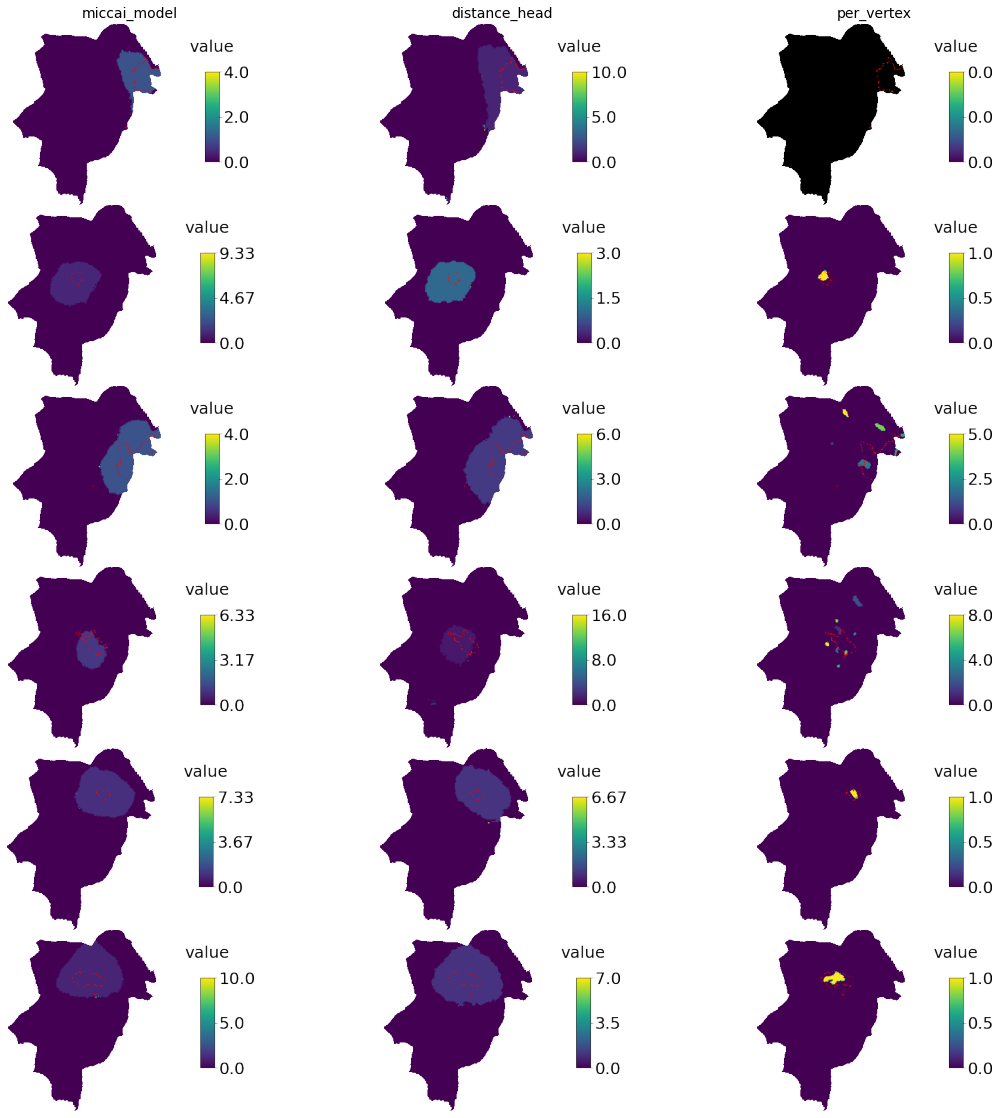

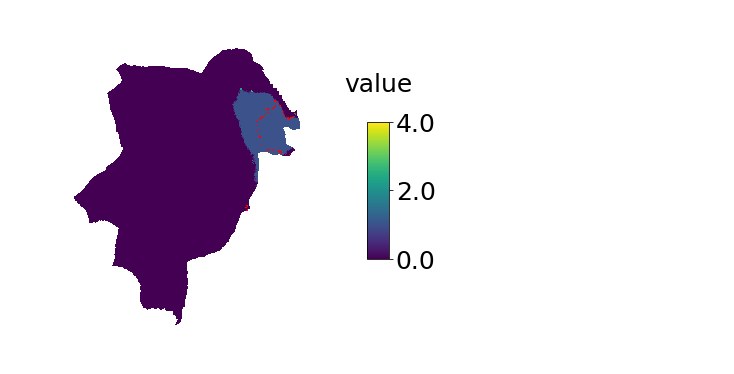

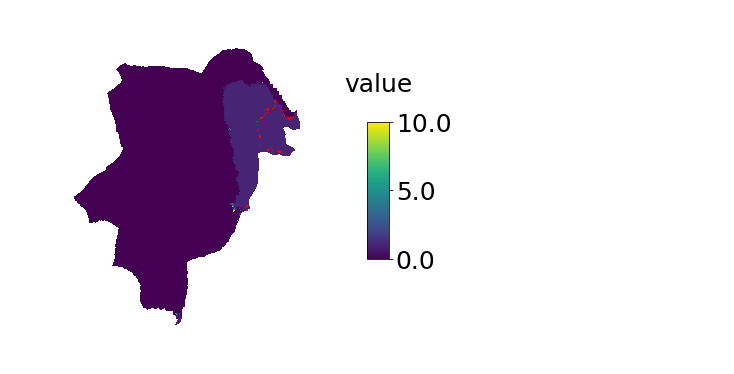

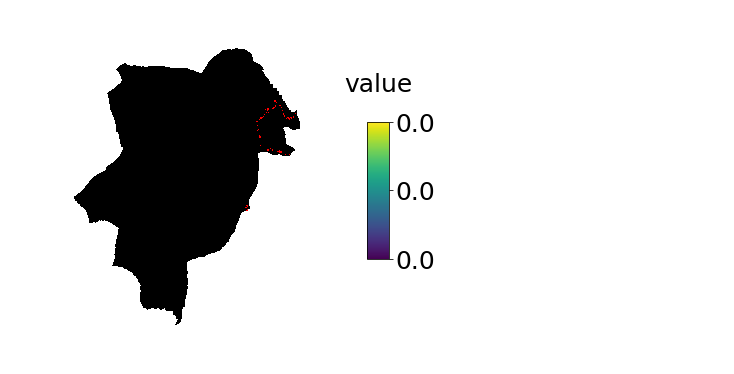

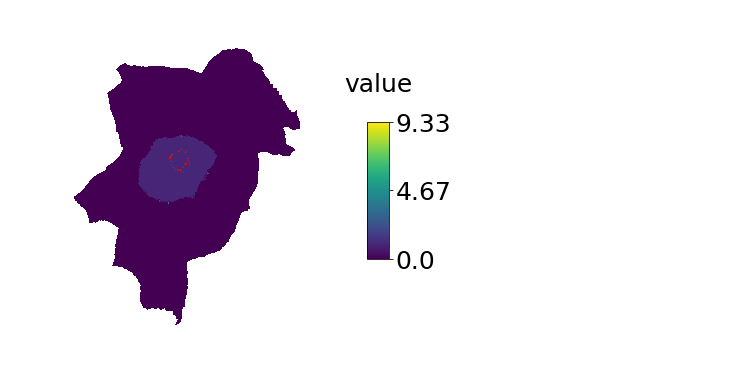

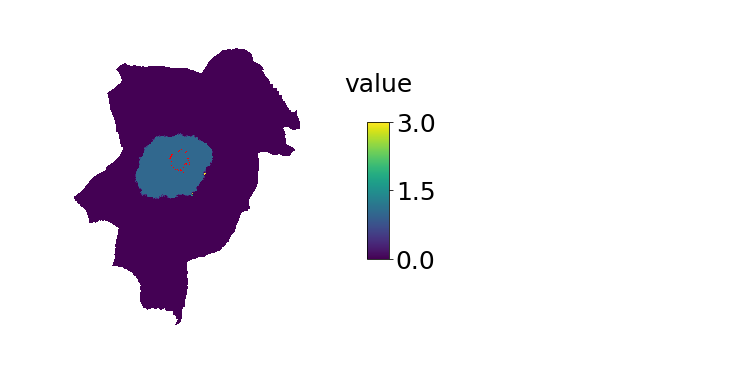

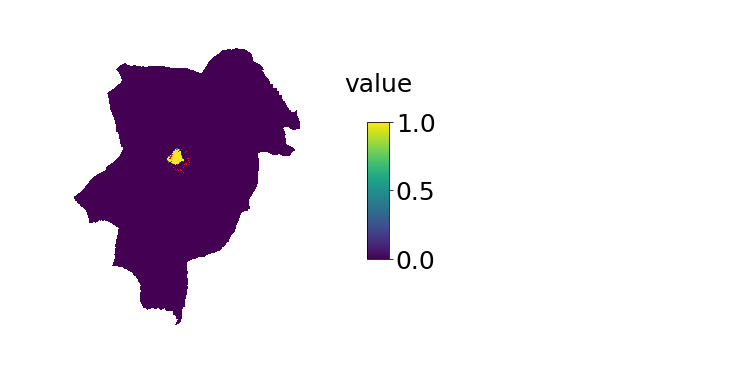

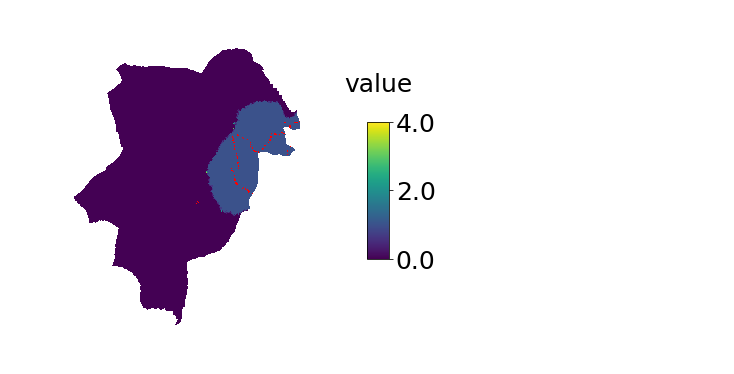

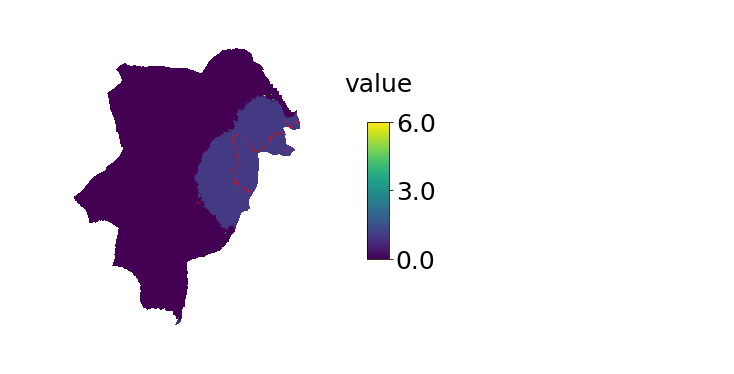

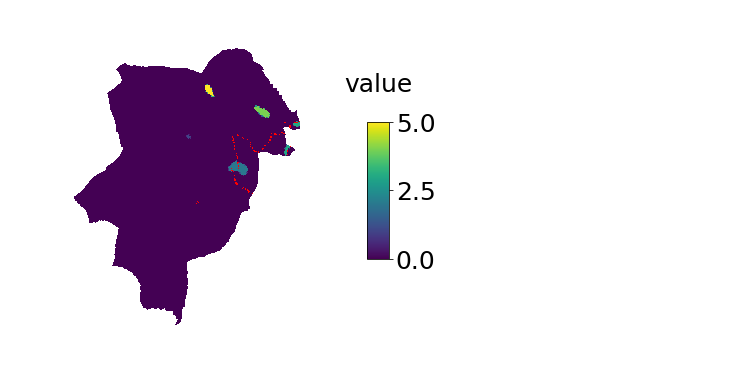

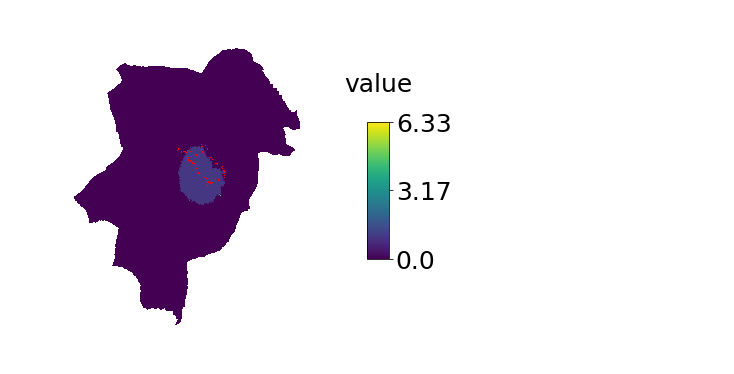

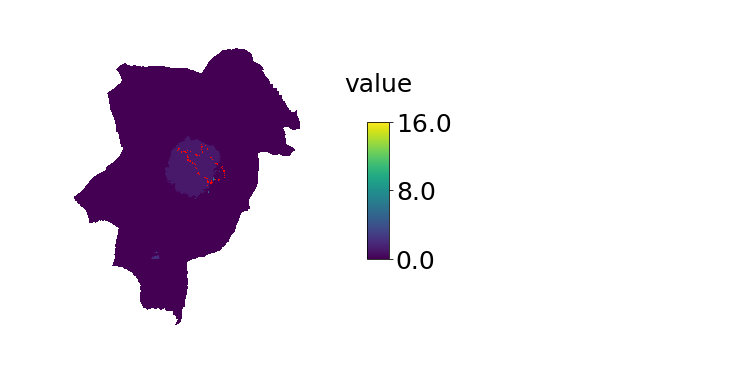

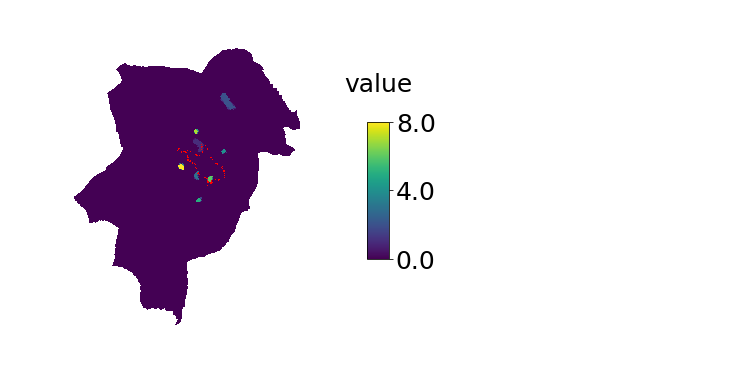

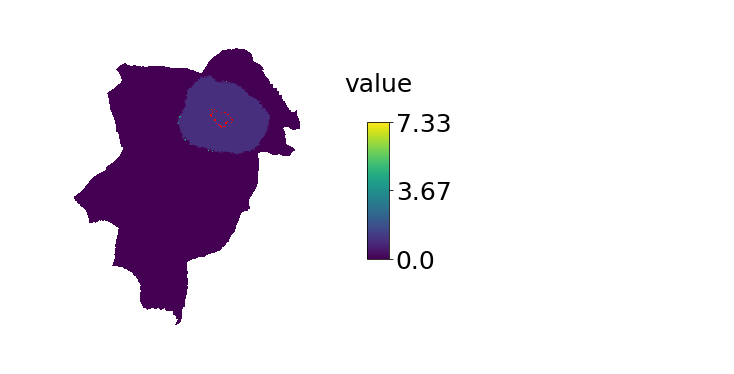

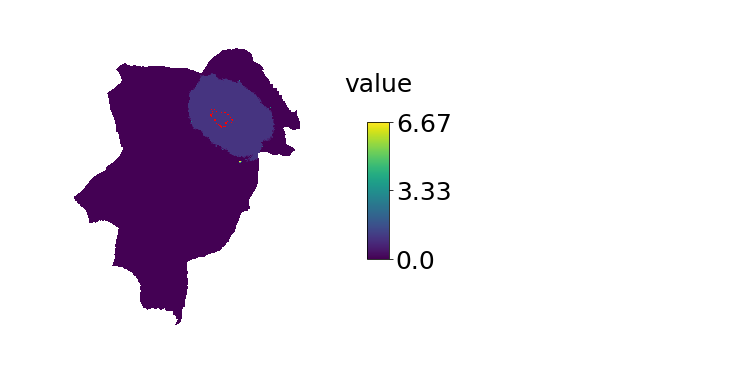

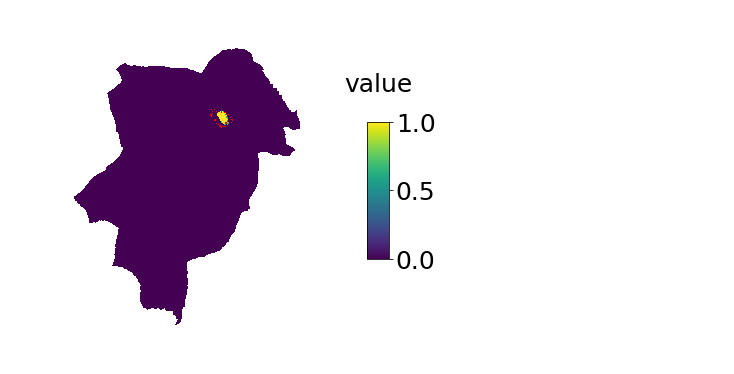

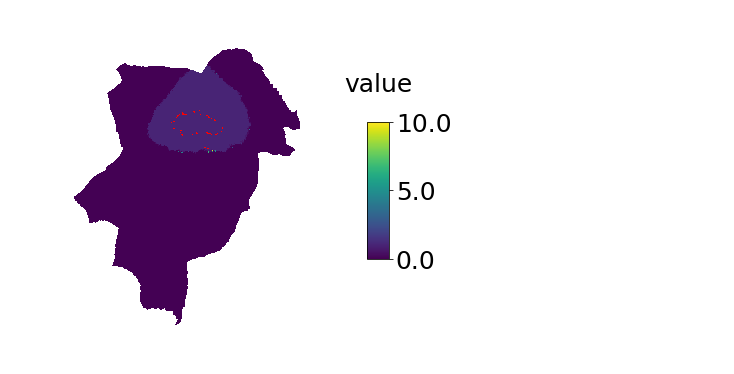

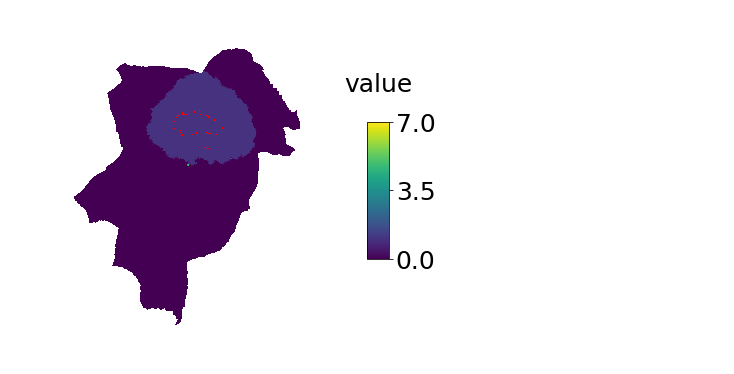

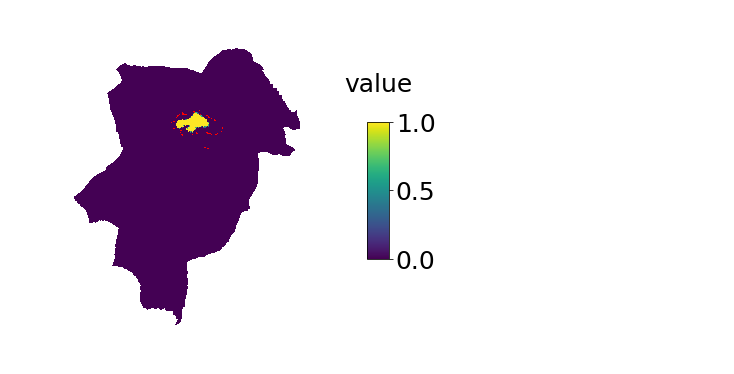

In [20]:
### plot few predictions
import nibabel as nb
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from meld_classifier.paths import BASE_PATH


subjects = ['MELD2_H7_3T_FCD_004', 
            'MELD_H11_3T_FCD_0041', 
            'MELD_H21_15T_FCD_0050',
            'MELD_H4_3T_FCD_0040',
            'MELD_H15_3T_FCD_0008',
            'MELD_H12_3T_FCD_0009']

fig= plt.figure(figsize=(20,20), constrained_layout=True)
gs1 = GridSpec(len(subjects), len(set(save_dirs)),  wspace=0, hspace=0)

flat = nb.load(os.path.join(BASE_PATH, "fsaverage_sym", "surf", "lh.full.patch.flat.gii"))
coords, faces = flat.darrays[0].data, flat.darrays[1].data

for i,subj in enumerate(subjects): 
    s = MeldSubject(subj,cohort=cohort)
    hemi_les= s.get_lesion_hemisphere()
    dists, labels_hemis = s.load_feature_lesion_data(features=['.on_lh.boundary_zone.mgh'], hemi=hemi_les, features_to_ignore=[])
    if np.sum(dists)==0:
        dists +=200
    labels = labels_hemis
    borderzones = dists<20

    for m,model in enumerate(set(save_dirs)):
        print(model)
        values={}
        if model == 'per_vertex':
            #load pred from old classifier
            pred_file_old = os.path.join(save_dirs['per_vertex'])
            result_hemis_old = load_prediction(subj,pred_file_old, dset='prediction')
            predictions_hemi =  np.zeros(len(cohort.cortex_mask))
            predictions_hemi[cohort.cortex_mask] = result_hemis_old[hemi_les]
        else:
            result_hemis={'lh':np.zeros(int(n_vert/2)),
                        'rh':np.zeros(int(n_vert/2)),}
            result_hemis_clustered={}
            for fold in folds:
                save_dir = save_dirs[model][fold]
                #load pred from new classifier and average over fold
                pred_file = os.path.join(save_dir, 'predictions.hdf5')
                result_hemis_fold = load_prediction(subj,pred_file, dset='prediction')
                result_hemis['lh'] += result_hemis_fold['lh']/len(folds)
                result_hemis['rh'] += result_hemis_fold['rh']/len(folds)
          
            #threshold new predictions
            mask = np.zeros(len(cohort.cortex_mask), dtype=bool)
            mask[cohort.cortex_mask] = (result_hemis[hemi_les] >= threshold_value)
            #cluster new predictions
            predictions_hemi = cluster_and_area_threshold(cohort, mask, min_area_threshold=min_area_threshold)

        #plot
        ax = fig.add_subplot(gs1[i,m])
        im = create_surface_plots(coords,faces,predictions_hemi,parcel= labels,flat_map=True,  )
        ax.imshow(im)
        if m==0:
            ax.set_ylabel(f'{subj}', fontsize=14) 
        if i==0:
            ax.set_title(f'{model}', fontsize=14)
        ax.axis('off')
    
    fig.savefig('/home/co-ripa1/rds/hpc-work/scripts/meld_classifier_GDL/images/example_lesions_models_0.03thresh.png')